In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import DataLoader, TensorDataset

import copy

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=";")

data = (data - data.mean())/data.std(ddof=1)

data_orig = copy.deepcopy(data)

In [3]:
nan = 10

value_nan = np.random.choice(range(len(data)), size=nan)

data["residual sugar"][value_nan] = np.nan

value_not_nan = np.where(~data["residual sugar"].isna())[0]

print(np.sort(value_nan))
print(np.where(data["residual sugar"].isna())[0])

[  11   25  358  448 1050 1167 1176 1222 1338 1346]
[  11   25  358  448 1050 1167 1176 1222 1338 1346]


In [4]:
columns_keep = data.keys()
columns_keep = columns_keep.drop("residual sugar")

train_data_tensor = torch.tensor(data[columns_keep].values).float()
train_data_tensor = train_data_tensor[value_not_nan, :]
train_label_tensor = torch.tensor(data["residual sugar"].values).float()
train_label_tensor = train_label_tensor[value_not_nan, None]

test_data_tensor = torch.tensor(data_orig[columns_keep].values).float()
test_data_tensor = test_data_tensor[value_nan, :]
test_label_tensor = torch.tensor(data_orig["residual sugar"].values).float()
test_label_tensor = test_label_tensor[value_nan, None]

print(f"Original Data: {data.shape}")
print(f"Train Data: {train_data_tensor.shape}")
print(f"Train Labels: {train_label_tensor.shape}")
print(f"Test Data: {test_data_tensor.shape}")
print(f"Test Labels: {test_label_tensor.shape}")

Original Data: (1599, 12)
Train Data: torch.Size([1589, 11])
Train Labels: torch.Size([1589, 1])
Test Data: torch.Size([10, 11])
Test Labels: torch.Size([10, 1])


In [5]:
train_dataset = TensorDataset(train_data_tensor, train_label_tensor)

batch_size = 32
train_data = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [6]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(11, 16)
        self.fc_1 = nn.Linear(16, 32)
        self.fc_2 = nn.Linear(32, 32)
        self.output = nn.Linear(32, 1)
    
    def forward(self, x):
        x = self.input(x)
        x = f.relu(x)
        x = self.fc_1(x)
        x = f.relu(x)
        x = self.fc_2(x)
        x = f.relu(x)
        return self.output(x)

In [7]:
model = Model()
loss_fun = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
num_epochs = 400

train_loss = torch.zeros(num_epochs)

for epoch in range(num_epochs):
    
    batch_loss = []
    for x, y in train_data:
        y_hat = model(x)
        
        loss = loss_fun(y_hat, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.item())
        
    train_loss[epoch] = np.mean(batch_loss)

In [9]:
y_hat_train = model(train_data_tensor)
y_hat_test = model(test_data_tensor)

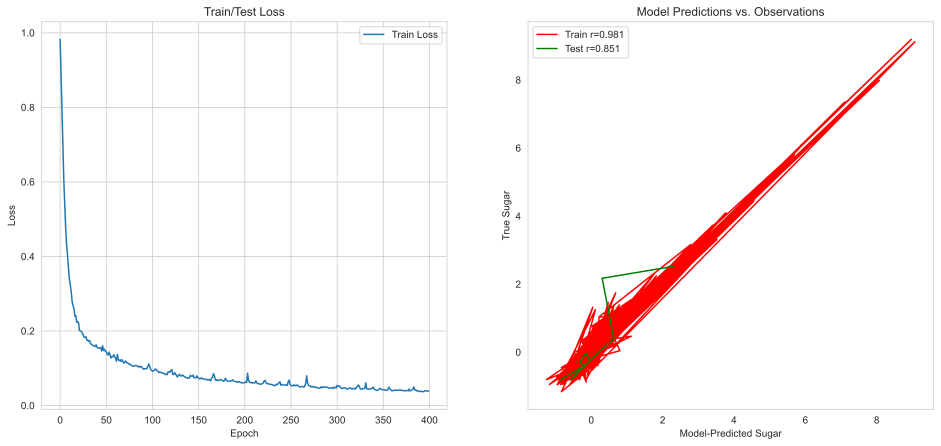

In [10]:
_, ax = plt.subplots(1, 2, figsize=(16, 7))

ax[0].plot(train_loss, label="Train Loss")
ax[0].set_title("Train/Test Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(y_hat_train.detach(), train_label_tensor, 'ro')
ax[1].plot(y_hat_test.detach(), test_label_tensor, 'g^')
ax[1].set_xlabel("Model-Predicted Sugar")
ax[1].set_ylabel("True Sugar")
ax[1].set_title("Model Predictions vs. Observations")

corr_train = np.corrcoef(y_hat_train.detach().T, train_label_tensor.T)[1, 0]
corr_test = np.corrcoef(y_hat_test.detach().T, test_label_tensor.T)[1, 0]
ax[1].legend([f"Train r={corr_train:0.3f}", f"Test r={corr_test:0.3f}"])
ax[1].grid();